In [1]:
"""
example script to compute frequency spectrum and extract snr of a target frequency

written by [Dominik Welke](dominik.welke[at]ae.mpg.de) - 28.02.2020
"""

import os
import json
import mne
import numpy as np
import matplotlib.pyplot as plt

## load data
the data I use have already been preprocessed via PREP pipeline implemented in EEGLAB 

see: https://doi.org/10.3389/fninf.2015.00016

In [2]:
# ----------------------------
dir_data = os.path.join(os.pardir, "3_data", "eeg")
dir_data_out = os.path.join(os.curdir, 'ftSNR')

# load eeg trigger structure / event_id
trigger_file = os.path.join(os.pardir, "2_stimuli", "aeeeg_trigger.json")
with open(trigger_file) as f:
    event_id = json.load(f)


# load eeg data - 

subject_id = 7

datafile = 'sub-%.2i_ses-01_task-aeEEG_eeg_prep.set' % subject_id
try:
    raw = mne.io.read_raw_eeglab(os.path.join(dir_data, 'derivatives', 'prep', datafile), preload=True)
    print('file %s loaded' % datafile)

except FileNotFoundError:
    print('file %s doesnt exist' % datafile)


file sub-07_ses-01_task-aeEEG_eeg_prep.set loaded


## minimal preprocessing pipeline
all these can be skipped, i dont really do much.

PREP data comes common-average rereferenced, change this if you like

In [3]:
""" set montage """
print('---')
print('SET MONTAGE')
print('---')

# load standard 10/20 template
montage_style = 'easycap-M1'
montage = mne.channels.make_standard_montage(montage_style,
                                             head_size=0.095)  # head_size parameter default = 0.095
raw = raw.pick(['eeg'], exclude=['ECG', 'EMG_arm'])
raw.set_montage(montage)  # set_dig=True is deprecated from 0.20 on
print(montage_style)


""" cleaning bad channels """
print('---')
print('DEFINE BAD CHANNELS')
print('---')

# bad channels were identfied before (using eeglab functions) and stored as json
do_badchans = False  # bad channels already interpolated during PREP routine
print(do_badchans)

if do_badchans:
    file_bads = os.path.join(os.pardir, '3_data', 'bad_chans', 'aeeegs%.2i_bads.txt' % subject_id)
    with open(file_bads) as f:
        tmp_bads = json.load(f)
    raw.info['bads'] = tmp_bads['bads_prob'] + tmp_bads[
        'bads_freq']  # keep bridged and kurtosis-rejected for now

picks_clean = mne.pick_types(raw.info, eeg=True, exclude='bads')

""" rereferencing -  after defining bad channels"""
print('---')
print('REREFERENCING')

do_reref =  None  # None or 'car', or specific electrode eg. 'nose'
print(do_reref)

if do_reref == 'car':
    raw.set_eeg_reference('average', projection=False)  # apply common average reref
elif do_reref is None:
    pass
else:
    raw.set_eeg_reference(ref_channels=[do_reref])


""" notch filter power line noise """
print('---')
print('NOTCH-FILTER')

do_notch = False
print(do_notch)

if do_notch:
    notch = np.arange(raw.info['line_freq'], raw.info['lowpass'], raw.info['line_freq'])
    raw.notch_filter(notch, filter_length='auto', phase='zero')


""" bandpass filter """
print('---')
print('BP FILTER')

do_bp = False
print(do_bp)

if do_bp:
    hp = .1  # for ica not below 1hz, otherwise .1 cutoff
    lp = 250.
    raw.filter(hp, lp, fir_design='firwin')




---
SET MONTAGE
---
easycap-M1
---
DEFINE BAD CHANNELS
---
False
---
REREFERENCING
None
---
NOTCH-FILTER
False
---
BP FILTER
False


## psd calculation
i use welchs method for frequency decomposition, since it is really fast. all the other methods implemented in MNE are possible as well

In [4]:
""" extract events """
print('---')
print('LOAD EVENTS')
print('---')

# get events using "mne.events_from_annotations(raw)"
events, _ = mne.events_from_annotations(raw)

raw.info["events"] = events

""" epoch data """
print('---')
print('EPOCH DATA')
print('---')

tmin, tmax = 0., 9.  # in s
baseline = None

epochs = mne.Epochs(
    raw, events=events, event_id=event_id['start/assr'], tmin=tmin,
    tmax=tmax, baseline=baseline)

""" get psd """
print('---')
print('COMPUTE/PLOT PSD')
print('---')

# pick electrodes
picks = picks_clean  # default, all good channels

# parameters
tmin = 1.
tmax = 9.
fmin = 1.
fmax = 90.
sf = epochs.info['sfreq']

# frequency decomposition
mode_psd = 'welch'  # implemented: 'welch', 'multitaper'
print('frequency decomposition using %s-method(s)' % mode_psd)

if mode_psd == 'multitaper':
    # multitaper
    psds, freqs = mne.time_frequency.psd_multitaper(
        epochs, bandwidth=.5,
        tmin=tmin, tmax=tmax, normalization='full',
        fmin=fmin, fmax=fmax, picks=picks)
elif mode_psd == 'welch':
    psds, freqs = mne.time_frequency.psd_welch(
        epochs,
        n_fft=int(sf * (tmax-tmin)), n_overlap=int(sf * .5), n_per_seg=None,
        tmin=tmin, tmax=tmax,
        fmin=fmin, fmax=fmax, picks=picks)



---
LOAD EVENTS
---
Used Annotations descriptions: ['S  1', 'S  2', 'S  3', 'S  4', 'S  5', 'S  6', 'S  7', 'S  8', 'S 10', 'S 11', 'S 13', 'S 14', 'empty']
---
EPOCH DATA
---
80 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
---
COMPUTE/PLOT PSD
---
frequency decomposition using welch-method(s)
Loading data for 80 events and 9001 original time points ...
0 bad epochs dropped
Effective window size : 8.000 (s)


## extract assr features
the function calculates ratio of bandpower in the signal bin to average power a set of noise bins. the composition of noise bins can be tweaked by two parameters: 
- how many noise bins do you want? 
- do you want to skip the n bins directly next to the signal bin?

In [5]:
def snr_spectrum(psds, noise_n_neighborfreqs=1, noise_skip_neighborfreqs=1):
    """
    Parameters
    ----------
    psds - np.array
        containing psd values as spit out by mne functions. must be 2d or 3d with frequencies in the last dimenstion
    noise_n_neighborfreqs - int
        number of neighboring frequencies used to compute noise level. increment by one to ad one frequency bin ON BOTH SIDES
    noise_skip_neighborfreqs - int
        set this >=1 if you want to exclude the immediately neighboring frequency bins in noise level calculation

    Returns
    -------
    snr - np.array
        array containing snr for all epochs, channels, frequency bins.
        NaN for frequencies on the edge, that do not have enoug neighbors on one side to calculate snr
    """

    # prep not epoched / single channel data
    is_2d = True if (len(psds.shape) == 2) else False
    if is_2d:
        psds = psds.reshape((1, psds.shape[0], psds.shape[1]))

    # SNR loop
    snr = np.empty(psds.shape)
    for i_freq in range(psds.shape[2]):

        # skip freqs on the edges (without noise neighbors)
        if not (psds.shape[2] - noise_n_neighborfreqs - noise_skip_neighborfreqs) > i_freq >= (noise_n_neighborfreqs + noise_skip_neighborfreqs):
            snr[:,:,i_freq] = np.nan
            continue

        # extract signal level
        signal = psds[:,:,i_freq]

        # ... and average noise level
        i_noise = []
        for i in range(noise_n_neighborfreqs):
            i_noise.append(i_freq + noise_skip_neighborfreqs + i + 1)
            i_noise.append(i_freq - noise_skip_neighborfreqs - i - 1)
        noise = psds[:,:,i_noise].mean(axis=2)

        snr[:,:,i_freq] = signal / noise

    # reshape not epoched / single channel data to original dimensions
    if is_2d:
        snr = snr.reshape(snr.shape[1], snr.shape[2])

    return snr

In [6]:
print('---')
print('CALCULATE SNR')
print('---')

# parameters
stim_freq = 40.
noise_n_neighborfreqs = 3
noise_skip_neighborfreqs = 1

print('compute SNR spectrum')
print('stimulation frequency:  %.1f Hz' % stim_freq)
print('noise band derived from %i pair(s) of neighboring frequency bins (skipping %i closest bin pair(s))' % (noise_n_neighborfreqs, noise_skip_neighborfreqs))

# compute snr spectrum from psds
snrs = snr_spectrum(psds, noise_n_neighborfreqs=noise_n_neighborfreqs, noise_skip_neighborfreqs=noise_skip_neighborfreqs)  # trial subselection can be done here

#psds_log = 10 * np.log10(psds)
#snrs_log = snr_spectrum(psds_log, noise_n_neighborfreqs=1, noise_skip_neighborfreqs=1)  # trial subselection can be done here

print('---')
print('EXTRACT SNR AT STIMULATION FREQUENCY')
print('---')

# find frequency bin containing stimulation frequency - ideally the exact stimulation frequency in the center
tmp_distlist = abs(np.subtract(freqs, stim_freq))
i_signal = np.where(tmp_distlist == min(tmp_distlist))[0][0]  # could be updated to support multiple frequencies

# extract and average snrs at this frequency
snrs_stim = snrs[:,:,i_signal]  # trial subselection can be done here
print('average SNR at %iHz (all channels, all trials): %.3f ' % (stim_freq, snrs_stim.mean()))


---
CALCULATE SNR
---
compute SNR spectrum
stimulation frequency:  40.0 Hz
noise band derived from 3 pair(s) of neighboring frequency bins (skipping 1 closest bin pair(s))
---
EXTRACT SNR AT STIMULATION FREQUENCY
---
average SNR at 40Hz (all channels, all trials): 4.672 


## visualization
lets check out frequency and snr-spectra for our data

---
Plot SNR


/Users/dominik.welke/miniconda2/envs/mne/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


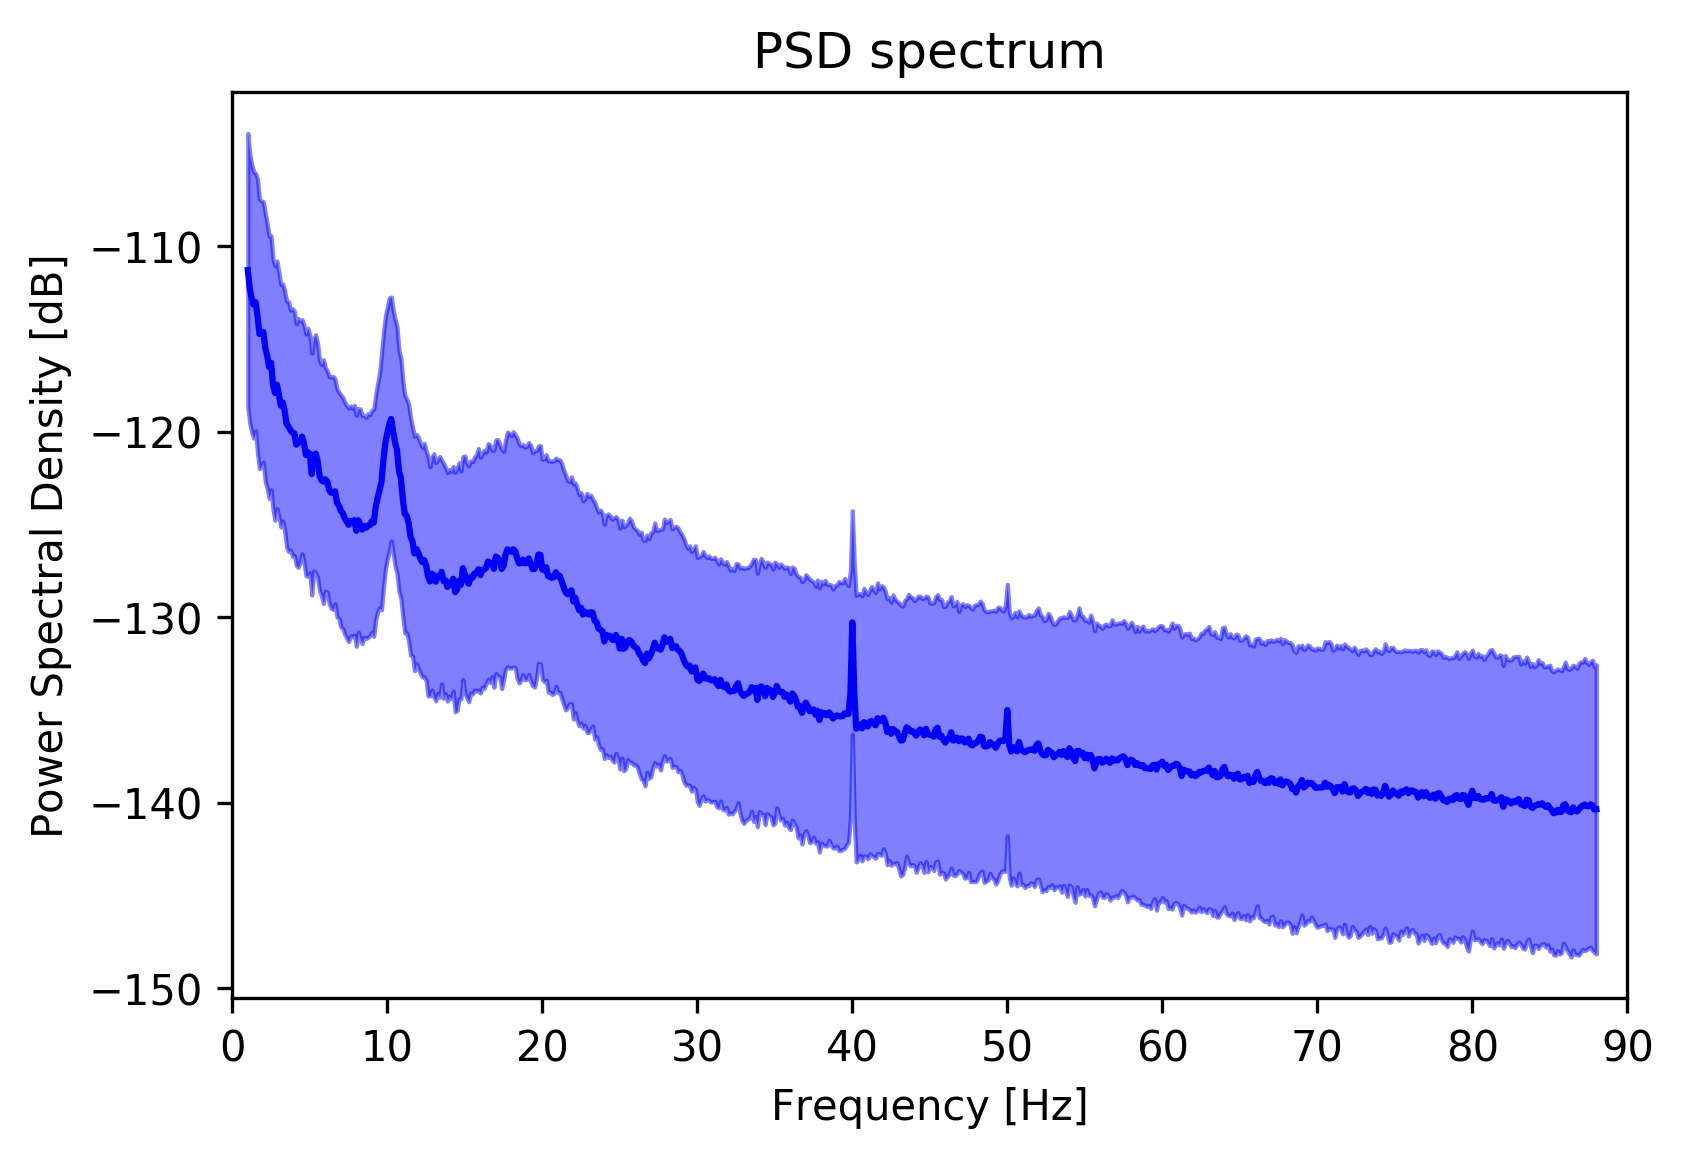

In [7]:
""" plot psd, if wanted """
print('---')
print('Plot SNR')

# psd

# code snippet from
# https://martinos.org/mne/stable/auto_examples/time_frequency/plot_compute_raw_data_spectrum.html
fig, axes = plt.subplots(1, 1, sharex='all', sharey='all', dpi=300)
rng = range(np.where(np.floor(freqs) == 1.)[0][0], np.where(np.ceil(freqs) == fmax-1)[0][
    0])  # psds_plot = np.sum([psds[i, j, :] for i in range(psds.shape[0]) for j in range(psds.shape[1])],0)

psds_plot = 10 * np.log10(psds)
psds_mean = psds_plot.mean((0, 1))[rng]
psds_std = psds_plot.std((0, 1))[rng]
axes.plot(freqs[rng], psds_mean, color='b')
axes.fill_between(freqs[rng], psds_mean - psds_std, psds_mean + psds_std,
                  color='b', alpha=.5)
axes.set(title="PSD spectrum", xlabel='Frequency [Hz]',
         ylabel='Power Spectral Density [dB]')
plt.xlim([0, fmax])
fig.show()


/Users/dominik.welke/miniconda2/envs/mne/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  
/Users/dominik.welke/miniconda2/envs/mne/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  app.launch_new_instance()


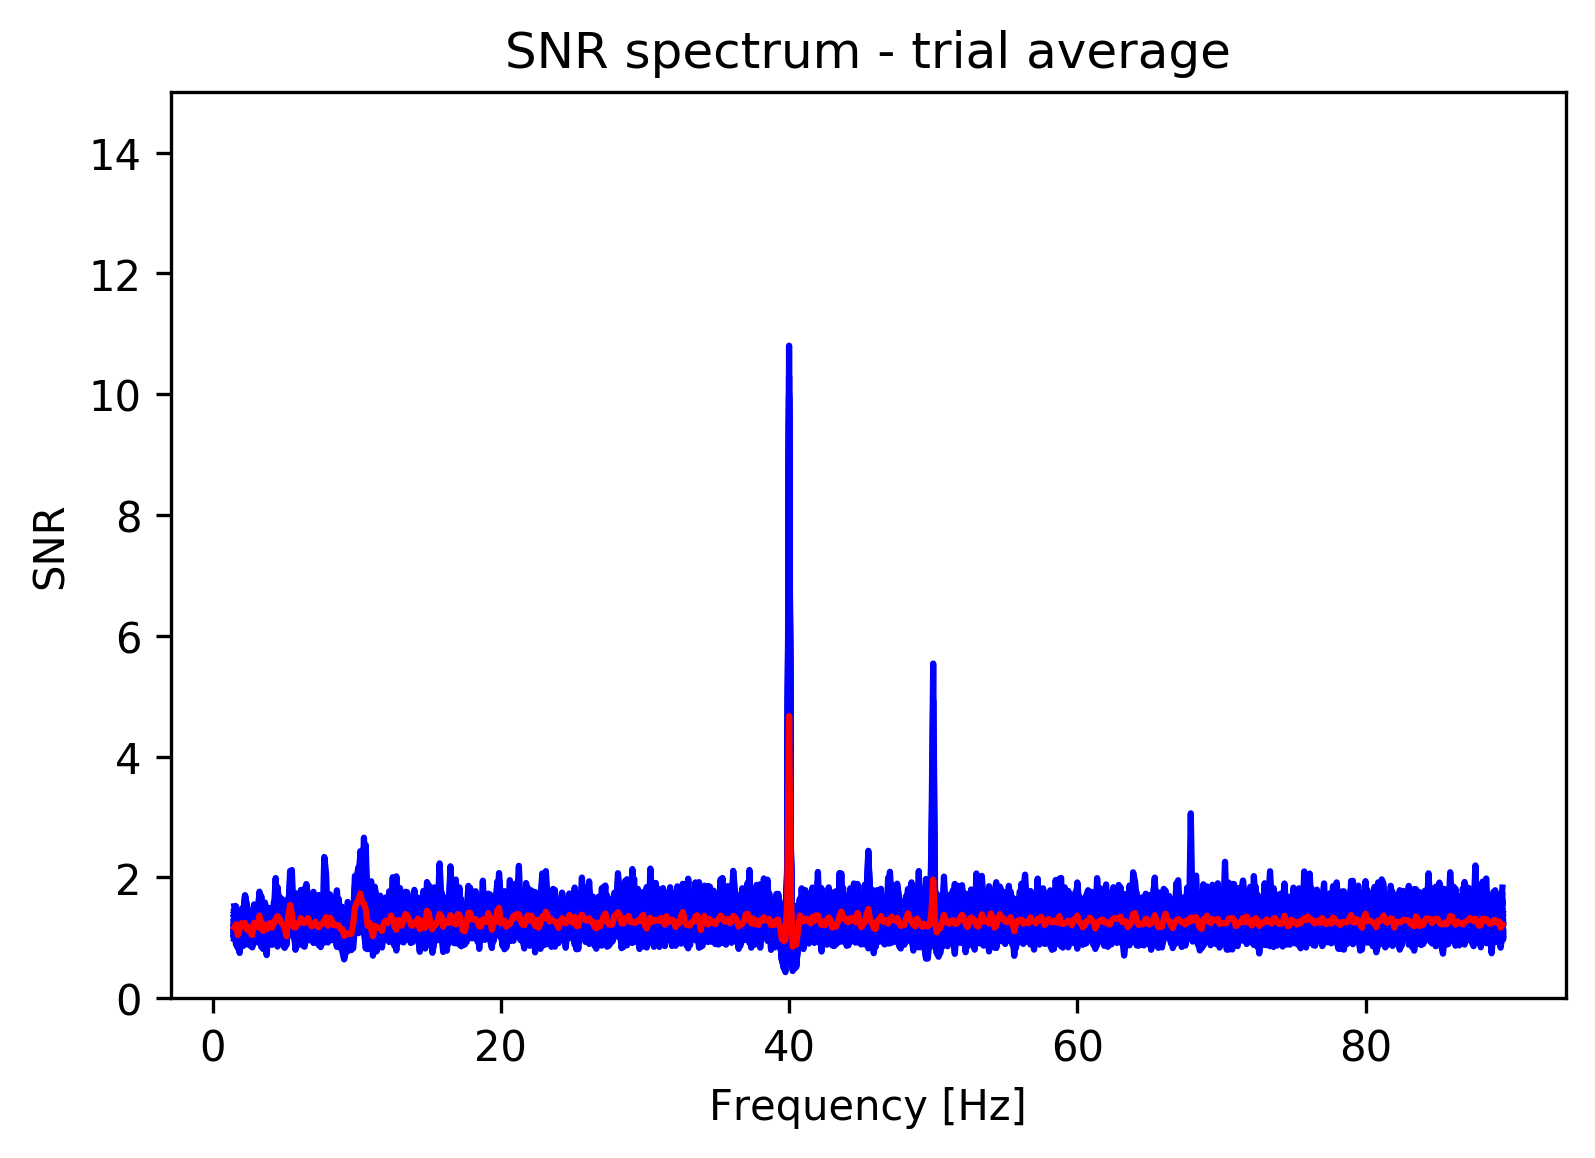

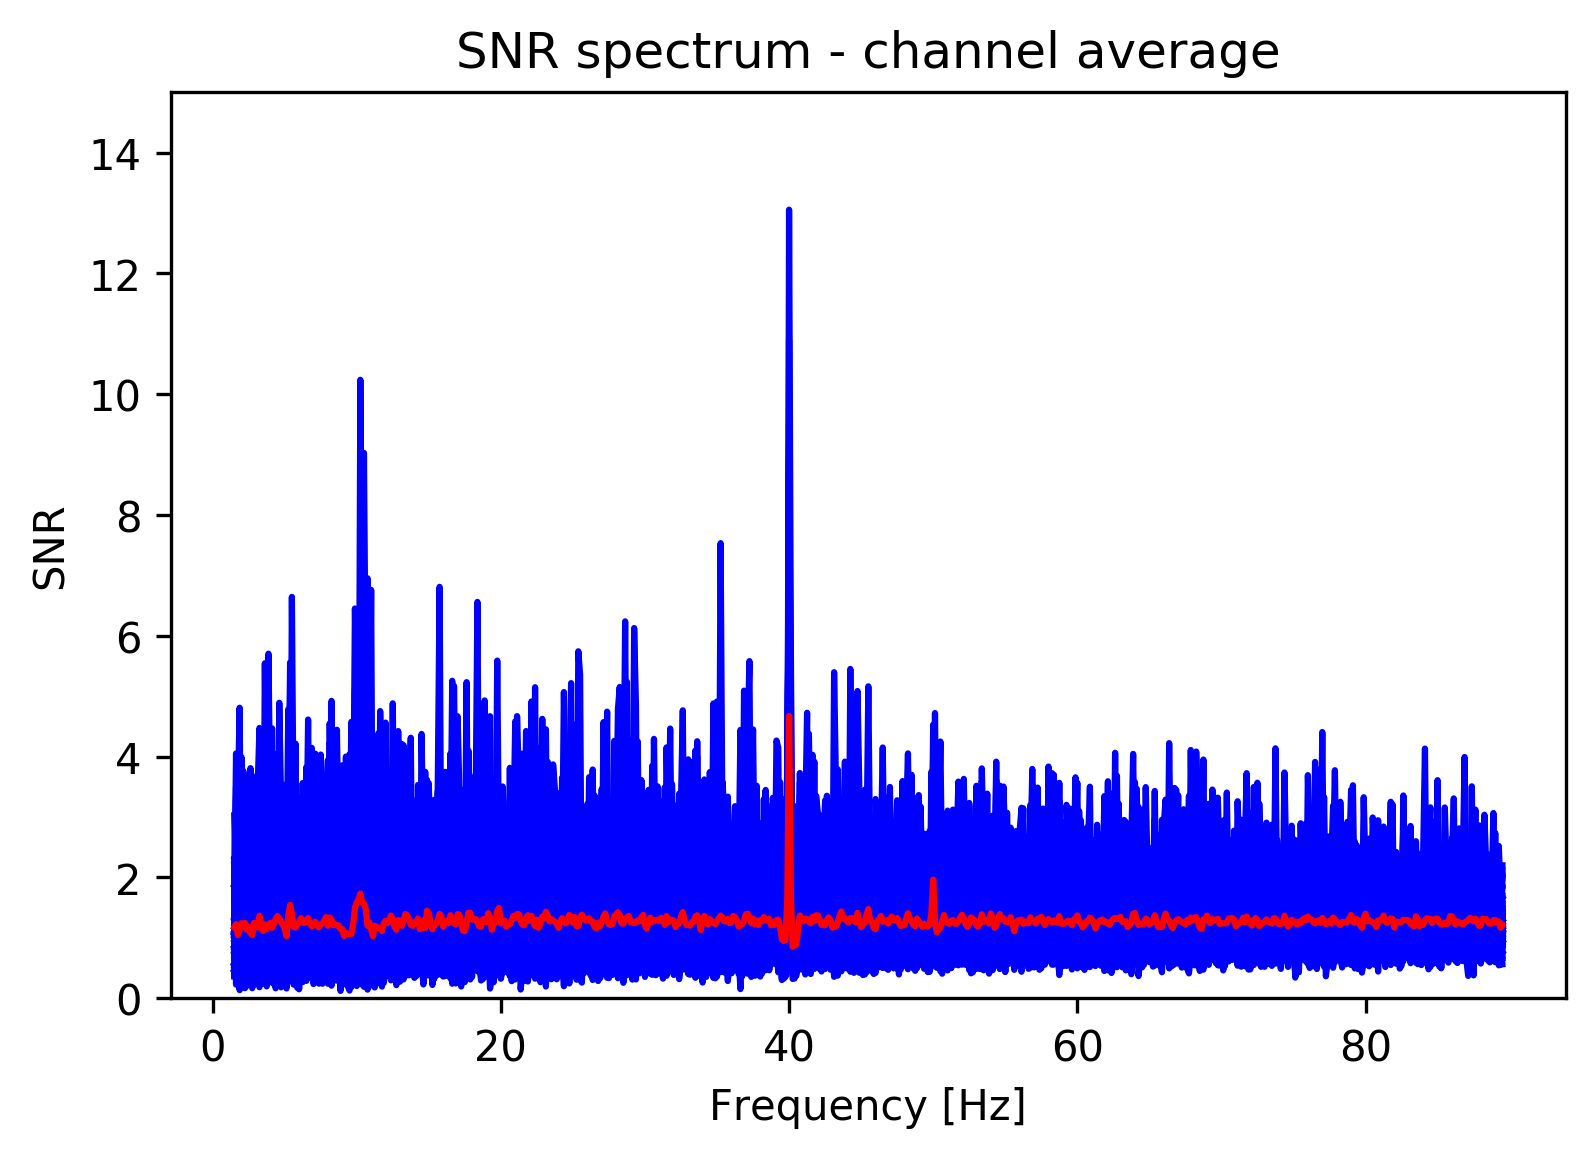

In [8]:
# snr spectrum - trial average 
fig, axes = plt.subplots(1, 1, sharex='all', sharey='all', dpi=300)
axes.plot(freqs,snrs.mean(axis=0).T, color='b')
snr_mean = snrs.mean(axis=0).mean(axis=0)
axes.plot(freqs, snr_mean.T, color='r')
axes.set(title="SNR spectrum - trial average", xlabel='Frequency [Hz]',
         ylabel='SNR', ylim=[0,15])
fig.show()

# snr spectrum - channel average
fig, axes = plt.subplots(1, 1, sharex='all', sharey='all', dpi=300)
axes.plot(freqs,snr_spectrum(psds[:,:,:],3,1).mean(axis=1).T, color='b')
axes.plot(freqs,snr_spectrum(psds[:,:,:],3,1).mean(axis=0).mean(axis=0), color='r')
axes.set(title="SNR spectrum - channel average", xlabel='Frequency [Hz]',
         ylabel='SNR', ylim=[0,15])
fig.show()


## subsetting data
for statistical comparison you probably want specific subsets of the SNR array. either some channels, or - obviously - different trials depending on the stimuli.

- so far, one needs to define the indices of the channels / trials by hand - not nice.
- alternatively, one can subset trials already at the epoch level using MNEs event information, and create individual PSD and SNR objects

In [9]:
""" snr for different sets of channels """

print('---')
print('SUBSET CHANNELS')
print('---')

# define ROIs
roi_temporal = ['T7', 'F7', 'T8', 'F8']  # temporal
roi_aud = ['AFz', 'Fz', 'FCz', 'Cz', 'CPz', 'F1', 'FC1',
           'C1', 'CP1', 'F2', 'FC2', 'C2', 'CP2']  # auditory roi
roi_vis = ['POz', 'Oz', 'O1', 'O2', 'PO3', 'PO4', 'PO7',
           'PO8', 'PO9', 'PO10', 'O9', 'O10']  # visual roi

picks_roi_temp = mne.pick_types(raw.info, eeg=True, stim=False, exclude='bads', selection=roi_temporal)
picks_roi_aud = mne.pick_types(raw.info, eeg=True, stim=False, exclude='bads', selection=roi_aud)
picks_roi_vis = mne.pick_types(raw.info, eeg=True, stim=False, exclude='bads', selection=roi_vis)

# subset data
snrs_trialwise_roi_aud = snrs_stim[:,picks_roi_aud]
snrs_trialwise_roi_vis = snrs_stim[:,picks_roi_vis]
snrs_trialwise_temp = snrs_stim[:,picks_roi_temp]

print('mean SNR (auditory ROI) at %iHz = %.3f ' % (stim_freq, snrs_trialwise_roi_aud.mean()))
print('mean SNR (visual ROI) at %iHz = %.3f ' % (stim_freq, snrs_trialwise_roi_vis.mean()))
print('mean SNR (temporal chans) at %iHz = %.3f ' % (stim_freq, snrs_trialwise_temp.mean()))
print('---')


""" snr for different sets of trials """
""" alternatively, one can subset trials already at the epoch level, compute PSD and SNR individually"""
print('---')
print('SUBSET TRIALS')
print('---')

# define trial subsets
i_cat1_1 = [i for i in range(40)]
i_cat1_2 = [i for i in range(40,80)]

# subset data
snrs_trialwise_cat1_1 = snrs_stim[i_cat1_1,:]
snrs_trialwise_cat1_2 = snrs_stim[i_cat1_2,:]

print('mean SNR (cat1:level1) at %iHz = %.3f ' % (stim_freq, snrs_trialwise_cat1_1.mean()))
print('mean SNR (cat1:level2) at %iHz = %.3f ' % (stim_freq, snrs_trialwise_cat1_2.mean()))
print('---')


---
SUBSET CHANNELS
---
mean SNR (auditory ROI) at 40Hz = 5.885 
mean SNR (visual ROI) at 40Hz = 7.071 
mean SNR (temporal chans) at 40Hz = 2.386 
---
---
SUBSET TRIALS
---
mean SNR (cat1:level1) at 40Hz = 4.139 
mean SNR (cat1:level2) at 40Hz = 5.206 
---


## statistics  
tbd

In [10]:
""" do stats """
# do stats
import pandas as pd
import seaborn as sns

data = pd.DataFrame(snrs_stim)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.336914,0.005617,0.667416,1.536846,5.445718,0.457316,0.417321,0.989589,12.132193,4.317603,...,0.342249,0.169259,0.362358,4.587312,0.777513,0.102523,0.445812,14.380082,7.122619,9.371376
1,3.453847,3.241368,1.549681,2.294746,2.369657,0.199799,0.261767,2.500242,4.988076,1.252942,...,2.703601,2.815815,1.169111,3.690275,2.843733,3.947713,2.706234,1.655119,3.083106,3.280849
2,0.650946,1.313501,1.371117,2.744414,2.612534,0.066014,2.135538,1.640453,10.418067,1.604474,...,0.682316,4.033726,1.325496,2.878639,0.612507,1.293029,0.440133,15.742427,2.266392,11.240045
3,2.551201,0.057065,3.072018,5.074940,12.938415,2.452885,1.481223,1.771524,40.350225,9.008435,...,3.481663,1.964313,1.223883,0.856142,4.474208,2.802979,6.806893,0.332333,2.539115,6.995153
4,4.437570,0.393304,1.883847,7.449340,35.117471,1.070794,0.266099,8.386307,12.742262,3.316007,...,1.146563,0.768928,1.103292,6.194550,1.292244,2.461008,1.574229,5.418277,14.014250,20.594909
